In [1]:
import psycopg2
import pandas as pd

connector = psycopg2.connect(host ="",
                            user ="postgres",
                            port = "",
                            password = "",
                            database = "E-commerce project" )

In [2]:
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import pycountry
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.patches as patches
%matplotlib inline
sns.set(rc={'figure.figsize':(16,8)})
sns.set_style("whitegrid")
sns.color_palette("dark")
plt.style.use("fivethirtyeight")

In [151]:
#cek konsisten ketersediaan data
testing = pd.read_sql_query("""select extract(year from order_purchase_timestamp) as tahun,
    extract(month from order_purchase_timestamp) as bulan,
    count(DISTINCT c.customer_id) as maus
    from orders o
    left join customers c 
    on o.customers_id = c.customer_id
    GROUP BY 1,2 """, connector)
testing

,tahun,bulan,maus
0,2016.0,9.0,4
1,2016.0,10.0,324
2,2016.0,12.0,1
3,2017.0,1.0,800
4,2017.0,2.0,1780
5,2017.0,3.0,2682
6,2017.0,4.0,2404
7,2017.0,5.0,3700
8,2017.0,6.0,3245
9,2017.0,7.0,4026


In [3]:
all_data = pd.read_sql_query("""WITH mau as 
(
select tahun,
round(avg(maus),1 ) as avg_mau
from (
    select extract(year from order_purchase_timestamp) as tahun,
    extract(month from order_purchase_timestamp) as bulan,
    count(DISTINCT c.customer_id) as maus
    from orders o
    left join customers c 
    on o.customers_id = c.customer_id
    GROUP BY 1,2) sub1
GROUP BY 1
),
new_cust as(
select extract(year from first_buy) as tahun,
count(1) as new_customer
from (
select c.customer_unique_id,
min(o.order_purchase_timestamp) as first_buy
from customers c
left join orders o
on c.customer_id = o.customers_id
GROUP BY 1)sub2
GROUP BY 1
),
repeat_cust as (
    select tahun,
count(DISTINCT customer_unique_id) as repeat_customer
from(select 
extract(year from o.order_purchase_timestamp ) as tahun,
c.customer_unique_id,
count(1) as freq_buy
from customers c
left join orders o 
on c.customer_id = o.customers_id
GROUP BY 1,2
having count(1) > 1)sub3
GROUP BY 1
),
avg_order_freq as (
select tahun,
round(avg(freq_order),2) as avg_customer_order
from (select 
extract(year from o.order_purchase_timestamp) as tahun,
c.customer_unique_id,
count(1) as freq_order
from customers c
left join orders o 
on c.customer_id = o.customers_id
GROUP BY 1,2)sub4
GROUP BY 1
)
select mau.tahun,
mau.avg_mau,
new_cust.new_customer,
repeat_cust.repeat_customer,
avg_order_freq.avg_customer_order
from mau
join new_cust on new_cust.tahun = mau.tahun
join repeat_cust on repeat_cust.tahun = mau.tahun
join avg_order_freq on avg_order_freq.tahun = mau.tahun
where mau.tahun > 2016 ;""" ,connector)
all_data["tahun"] = all_data["tahun"].astype("str")
all_data = all_data.rename(columns={"avg_mau" : "avg_monthly_customer_active_users"})
all_data

,tahun,avg_monthly_customer_active_users,new_customer,repeat_customer,avg_customer_order
0,2017.0,3758.4,43708,1256,1.03
1,2018.0,5401.1,52062,1167,1.02


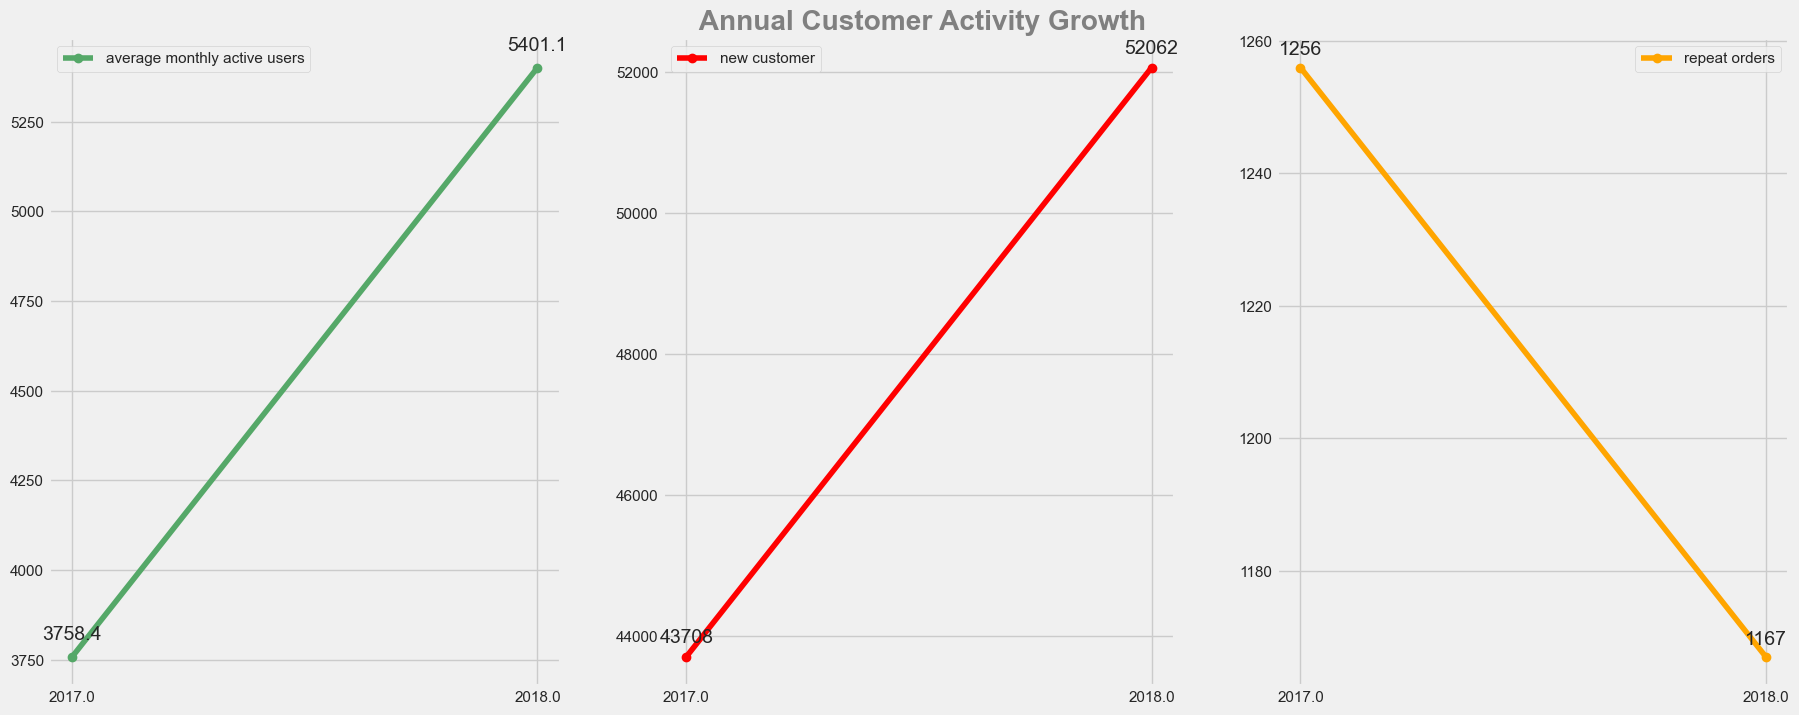

In [34]:
fig, ax =  plt.subplots(1, 3, figsize=(20,8))
ax[0].plot(all_data['tahun'], all_data['avg_monthly_customer_active_users'], color='g', label='average monthly active users', marker = "o")
ax[1].plot(all_data['tahun'], all_data['new_customer'], color='red', label='new customer', marker = "o")
ax[2].plot(all_data['tahun'], all_data['repeat_customer'], color='orange', label='repeat orders', marker = "o")
ax[0].legend(loc=2)
ax[1].legend(loc=2)
ax[2].legend(loc= "upper right")
ax[1].set_title(" Annual Customer Activity Growth", ha = "center" , fontweight = "bold", color = "grey")

for i,j in all_data.new_customer.items():
    ax[1].annotate(str(j), xy=(i, j), xytext=(0, 10), textcoords='offset points', ha='center')

for i,j in all_data.repeat_customer.items():
    ax[2].annotate(str(j), xy=(i, j), xytext=(0, 9), textcoords='offset points', ha='center')

for i,j in all_data.avg_monthly_customer_active_users.items():
    ax[0].annotate(str(j), xy=(i, j), xytext=(0, 12), textcoords='offset points', ha='center')

Text(-0.351, 1.0555, '\nrata rata frequency pembelian customer \nhanya sekali selama 2 tahun, hal ini \nterlihat tidak bagus maka perlu melakukan \nanalisis lebih mendalam untuk mengatasi\nhal ini. ')

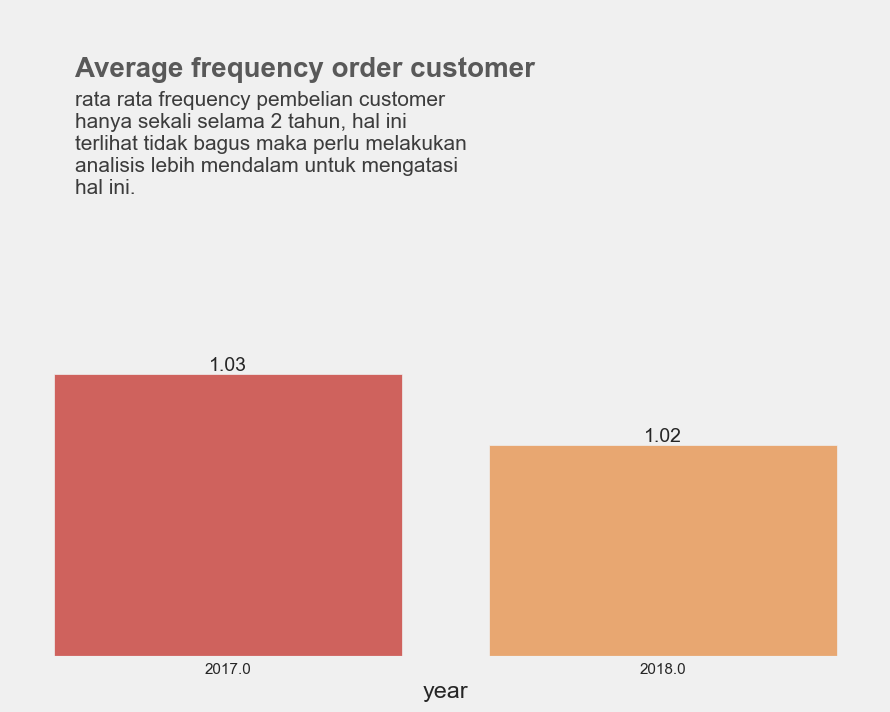

In [33]:
plt.figure(figsize= (10,8))
viz = sns.barplot(data = all_data, x = "tahun", y= 'avg_customer_order',palette=sns.color_palette("Spectral"))
plt.ylim(0.99)
total = all_data["avg_customer_order"].count()
for value in viz.containers:
  plt.bar_label(value)

plt.xlabel("year")
plt.yticks([])
plt.ylabel("")
title = """
Average frequency order customer"""
plt.text(x = -0.351, y = 1.072, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
text = """
rata rata frequency pembelian customer 
hanya sekali selama 2 tahun, hal ini 
terlihat tidak bagus maka perlu melakukan 
analisis lebih mendalam untuk mengatasi
hal ini. """
plt.text(x = -0.351, y = 1.0555, s=text,
        fontsize = 15,color= "black",alpha = .75)

Observasi customer activity growth mengalami kenaikan dari setiap tahun mulai dari 2017 hingga 2018, akan tetapi pada tahun 2016 memiliki keterbatasan data yang dimana data pada tahun 2016 hanya tersedia mulai pada bulan september 2016 saja sehingga memiliki kecenderungan inkosistensi data, agar terhindar dari hal itu maka tidak akan ditampilkan. secara keseluruhan mulai dari monthly active users dan new customer mengalami kenaikan setiap tahunya sekitar 44% dari MAU dan 22% dari new customer hal ini terlihat bagus untuk perusahaan karena dapat dipastikan peningkatan customer setiap tahun, akan tetapi jika dilihat dari repeat order yang dilakukan customer bisa dilihat pada grafik line chart yang sudah disajikan terlihat tidak bagus dan mengalami penurunan dari tahun 2017 ke tahun 2018, sedangkan jika dilihat dari average frequency order kebanyakan customer hanya melakukan 1x pembelian setiap tahun nya.


In [107]:
anual_product = pd.read_sql_query("""with rty as ( --total revenue year
SELECT 
extract (year from o.order_purchase_timestamp) as year,
round(sum(oi.price + oi.freight_value)) as revenue
from orders o 
join order_item oi 
on o.order_id = oi.order_id 
where o.order_status = 'delivered'
GROUP BY 1 
order by 1
),
co as( -- canceled order
select 
extract(year from order_purchase_timestamp) as year,
count(order_id) as canceled_order
from orders
where order_status = 'canceled'
GROUP BY 1
order by 1 asc
),
tp as( -- top product
select 
year,
most_top_product,
qty_top_product,
product_revenue
from(select 
extract(year from o.order_purchase_timestamp) as year,
p.product_category_name as most_top_product,
count(2) as qty_top_product,
round(sum(oi.price + oi.freight_value)) as product_revenue,
rank()over(PARTITION BY extract(year from o.order_purchase_timestamp) order by sum(oi.price + oi.freight_value) desc) as rank_product 
from orders o 
join order_item oi 
on o.order_id = oi.order_id
join products p 
on oi.product_id = p.product_id 
where order_status = 'delivered'
GROUP BY 1,2) as subq
where rank_product = 1
),
cp as ( -- canceled product
select 
year,
most_canceled_product,
qty_top_canceled_order
from(select 
extract(year from o.order_purchase_timestamp) as year,
p.product_category_name as most_canceled_product,
count(2) as qty_top_canceled_order,
rank()over(PARTITION BY extract(year from o.order_purchase_timestamp) order by count(2) desc) as rank_product 
from orders o 
join order_item oi 
on o.order_id = oi.order_id
join products p 
on oi.product_id = p.product_id 
where order_status = 'canceled'
GROUP BY 1,2) as subq
where rank_product = 1
)
select 
rty.year,
rty.revenue as year_total_revenue,
co.canceled_order as year_total_cancel_order,
tp.most_top_product,
tp.qty_top_product,
tp.product_revenue as top_product_revenue,
cp.most_canceled_product,
cp.qty_top_canceled_order
from rty
join co on rty.year = co.year 
join tp on rty.year = tp.year 
join cp on rty.year = cp.year
where rty.year > 2016;
;""", connector)


,year,year_total_revenue,year_total_cancel_order,most_top_product,qty_top_product,top_product_revenue,most_canceled_product,qty_top_canceled_order
0,2017.0,6921535,265,bed_bath_table,5135,580949,sports_leisure,25
1,2018.0,8451585,334,health_beauty,5841,866810,health_beauty,27


In [95]:
(6921535-46654/46654) * 100

692153400.0

In [61]:
#anual_product["year"] = anual_product["year"].apply(lambda x: int(x))

Text(0.1, 8320000, ' \nDalam hal revenue perusahaan mengalami pertumbuhan \nrevenue sebesar 22% dari  tahun 2017 ke 2018, hal ini \nmenunjukan bahwa perusahaan mengalami pertumbuhan \nrevenue yang cukup signifikan.\n')

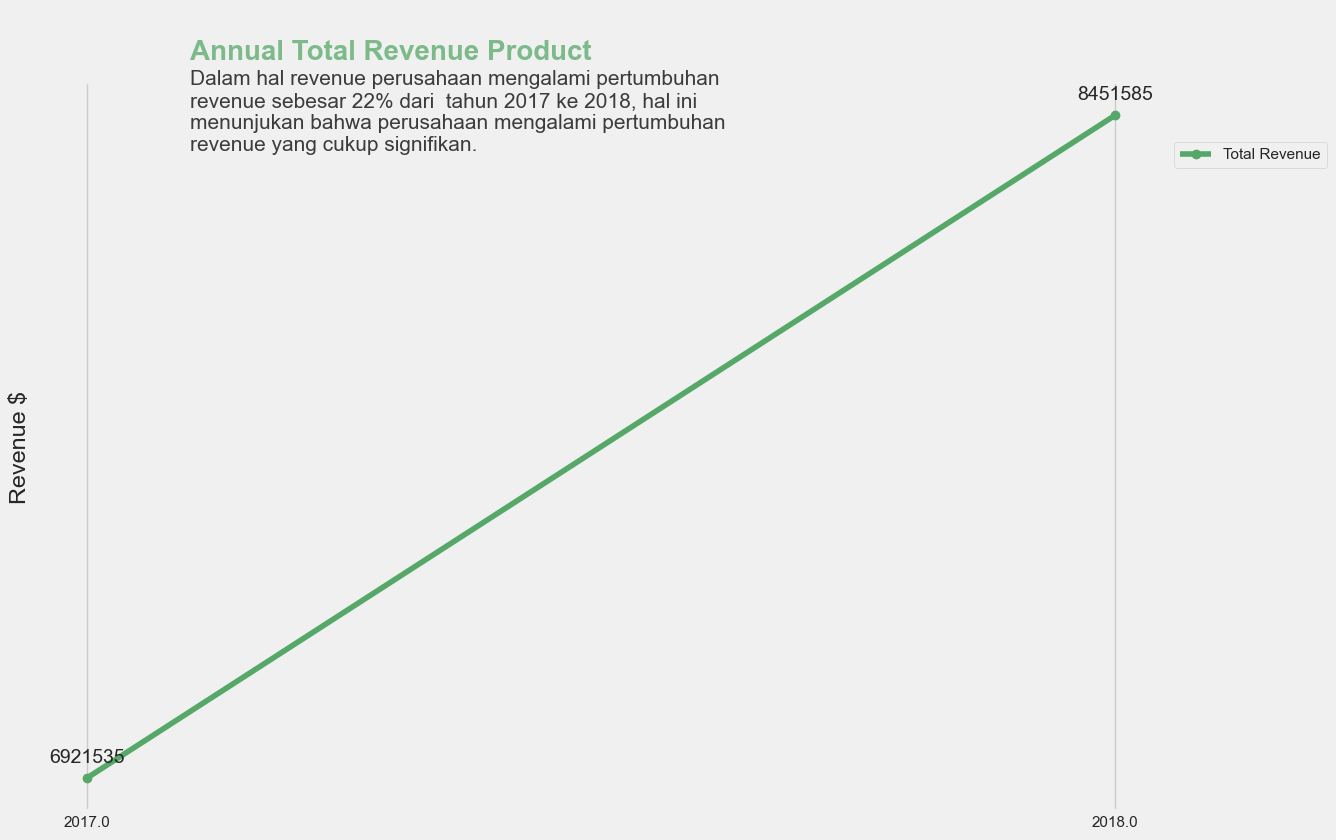

In [90]:
plt.figure(figsize= (13,9))
plt.plot(anual_product['year'],anual_product['year_total_revenue'], color='g', label='Total Revenue', marker = "o")

for i,j in anual_product.year_total_revenue.items():
    plt.annotate(str(j), xy=(i, j), xytext=(0, 11), textcoords='offset points', ha='center')

plt.yticks([])
plt.ylabel("Revenue $")
#plt.grid("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

title = """
Annual Total Revenue Product """
plt.text(x = 0.100000, y = 8580000, s=title,
        fontsize = 20, weight = 'bold', alpha = .75,
        color = "g")

text = """ 
Dalam hal revenue perusahaan mengalami pertumbuhan 
revenue sebesar 22% dari  tahun 2017 ke 2018, hal ini 
menunjukan bahwa perusahaan mengalami pertumbuhan 
revenue yang cukup signifikan.
"""

plt.text(x = 0.100000, y = 8320000, s=text,
        fontsize = 15, alpha = .75,
        color = "black")


Text(0.4, 340, '\nTotal Qty Cancel Order Product ')

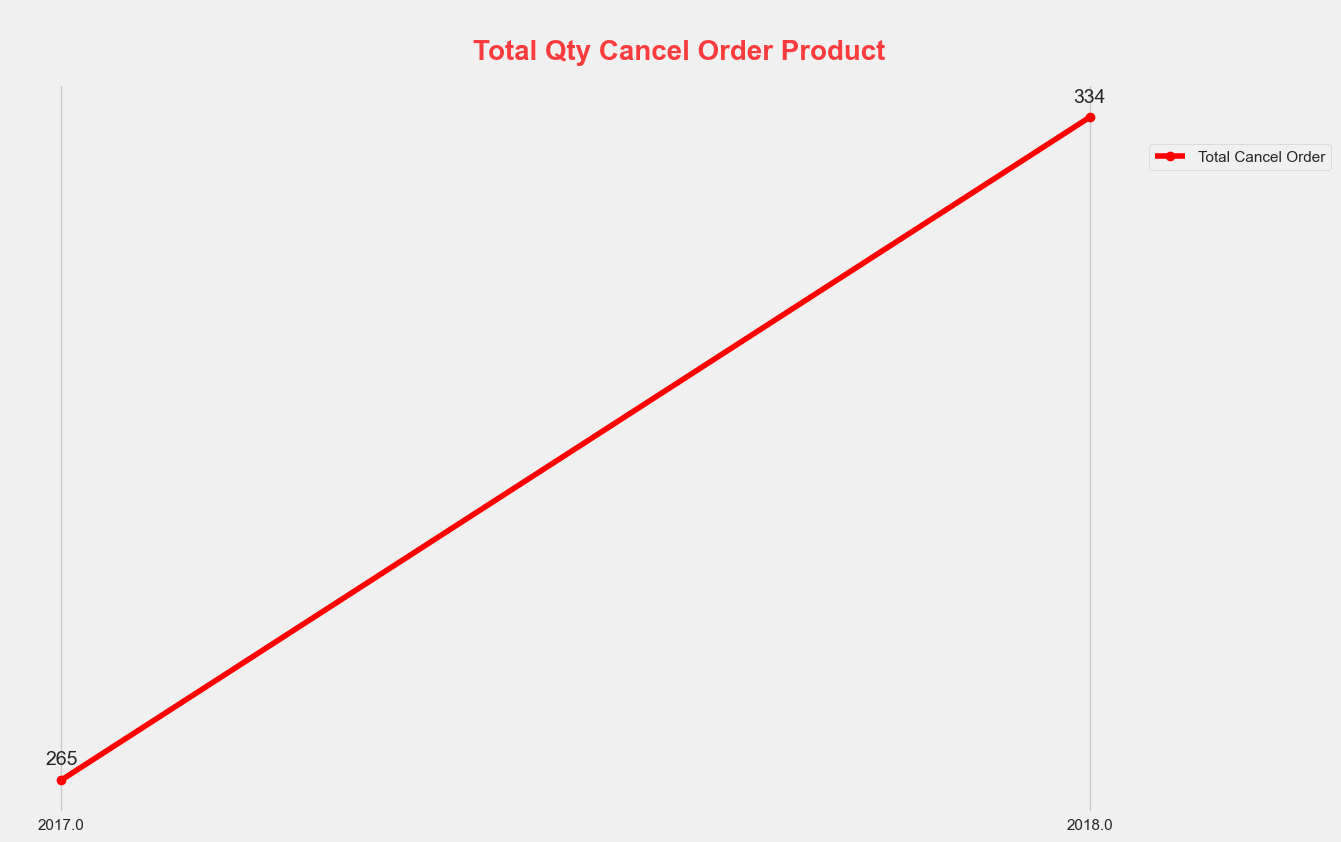

In [103]:
plt.figure(figsize= (13,9))
plt.plot(anual_product['year'],anual_product['year_total_cancel_order'], color='red', label='Total Cancel Order', marker = "o")

for i,j in anual_product.year_total_cancel_order.items():
    plt.annotate(str(j), xy=(i, j), xytext=(0, 11), textcoords='offset points', ha='center')

plt.yticks([])
plt.ylabel("")
#plt.grid("")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

title = """
Total Qty Cancel Order Product """
plt.text(x = 0.4000, y = 340 , s=title,
        fontsize = 20, weight = 'bold', alpha = .75,
        color = "red")

Disajikan dua grafik diatas maka dapat disimpulkan bahwa revenue mengalami peningkatan dari tahun 2016 hingga tahun 2018, akan tetapi seperti yang sudah dijelaskan diawal bahwa pada tahun 2016 memiliki keterbatasan data yang dimulai pada bulan september hingga desember sehingga tidak akan ditampilkan untuk visualisasi agar terhindar dari inkosistensi data. Dari grafik diatas menunjukan kenaikan sebesar 22% dari tahun 2017 hingga 2018 menunjukkan bahwa perusahaan telah berhasil meningkatkan pendapatannya, yang dapat disebabkan oleh berbagai faktor seperti peningkatan penjualan produk, ini bisa menjadi tanda bahwa perusahaan mengalami kondisi yang baik pada pertumbuhan revenue per tahun nya.

In [108]:
anual_product["year"] = anual_product["year"].apply(lambda x: int(x))

Text(-0.4, 846000, '\nBisa dilihat bahwa bar chart yang ditampilkan cukup \nmenarik karena banyak revenue yang didapat \nberasal dari category health beauty, dan juga \npada category health beauty sangat mendominasi \npenjualan dibanding tahun sebelumnya.\n\n')

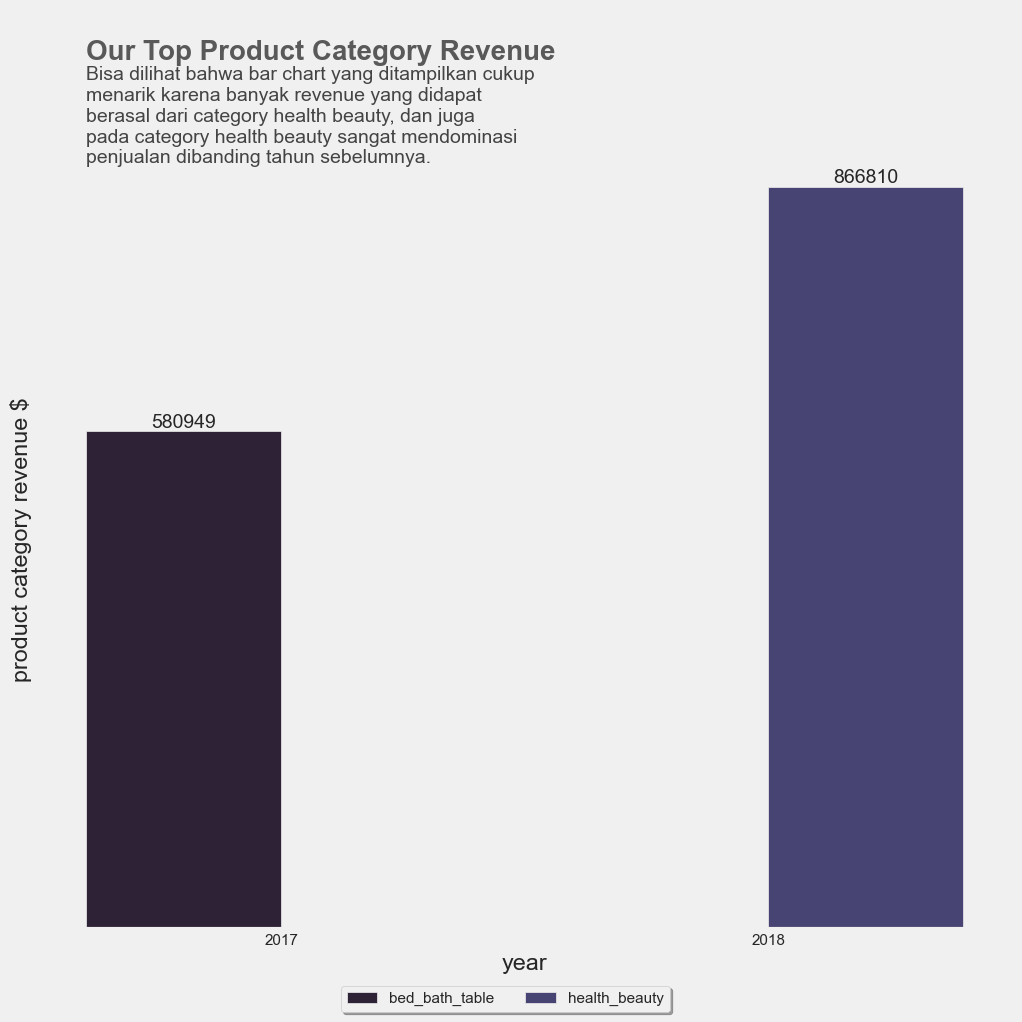

In [301]:
plt.figure(figsize= (11,9))
product = sns.barplot(data= anual_product, x="year", y = "top_product_revenue" , hue= "most_top_product" , palette=sns.color_palette("mako"))
plt.legend(loc='center', bbox_to_anchor=(0.48, -0.09),
          fancybox=True, shadow=True, ncol=5)

for value in product.containers:
  plt.bar_label(value)
plt.ylabel("product category revenue $")
plt.grid("")
plt.tight_layout()
plt.yticks([])

title = """
Our Top Product Category Revenue
"""
# set text
text = """
Bisa dilihat bahwa bar chart yang ditampilkan cukup 
menarik karena banyak revenue yang didapat 
berasal dari category health beauty, dan juga 
pada category health beauty sangat mendominasi 
penjualan dibanding tahun sebelumnya.

"""

plt.text(x = -0.4, y = 980000, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = -0.4, y = 846000, s=text,
        fontsize = 14, alpha = .85)


In [299]:
total = (866810/ sum(anual_product.top_product_revenue))*100

In [300]:
total

59.872534033634054

In [297]:
anual_product

,year,year_total_revenue,year_total_cancel_order,most_top_product,qty_top_product,top_product_revenue,most_canceled_product,qty_top_canceled_order
0,2017,6921535,265,bed_bath_table,5135,580949,sports_leisure,25
1,2018,8451585,334,health_beauty,5841,866810,health_beauty,27


Text(-0.01, 6300, '\nThe most delivered order product')

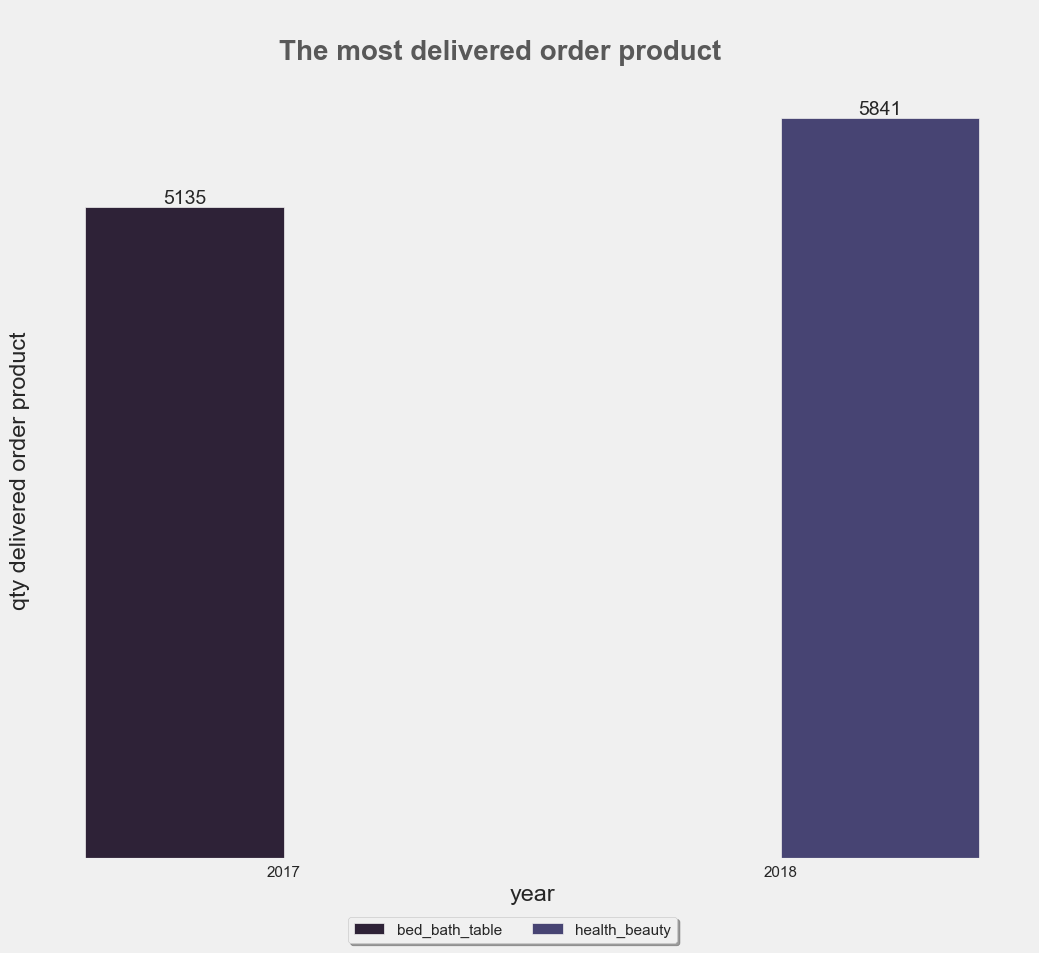

In [147]:
plt.figure(figsize= (11,9))

product = sns.barplot(data= anual_product, x="year", y = "qty_top_product" , hue= "most_top_product" , palette=sns.color_palette("mako"))
plt.legend(loc='center', bbox_to_anchor=(0.48, -0.09),
          fancybox=True, shadow=True, ncol=5)
for value in product.containers:
  plt.bar_label(value)

plt.ylabel("qty delivered order product")
plt.grid("")
plt.tight_layout()
plt.yticks([])

title = """
The most delivered order product"""

plt.text(x = -0.01, y = 6300, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)


Text(-0.01, 30, '\nThe most canceled order product')

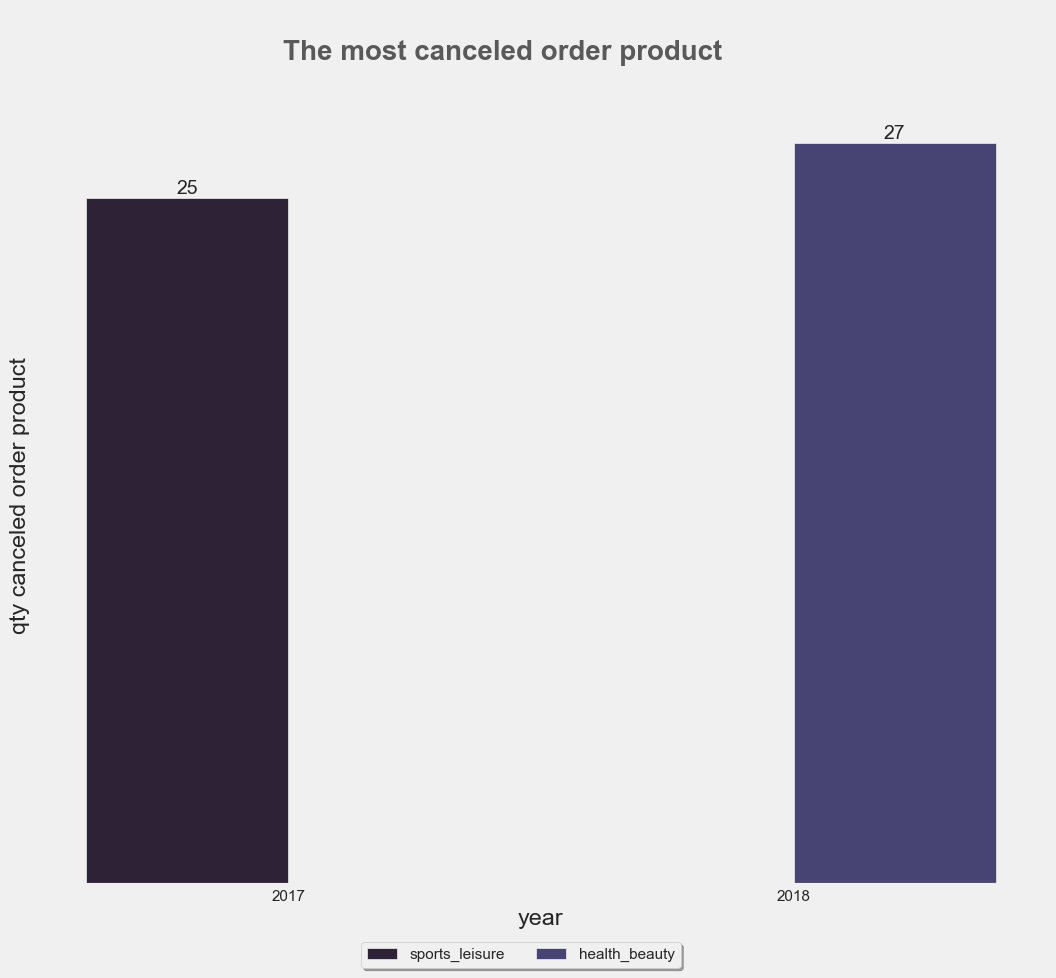

In [143]:
plt.figure(figsize= (11,9))

product = sns.barplot(data= anual_product, x="year", y = "qty_top_canceled_order" , hue= "most_canceled_product" , palette=sns.color_palette("mako"))
plt.legend(loc='center', bbox_to_anchor=(0.48, -0.09),
          fancybox=True, shadow=True, ncol=5)
for value in product.containers:
  plt.bar_label(value)

plt.ylabel("qty canceled order product")
plt.grid("")
plt.tight_layout()
plt.yticks([])

title = """
The most canceled order product"""


plt.text(x = -0.01, y = 30, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)



disajikan dari ketiga grafik tersebut bahwa dari tahun 2017 hingga 2018, product yang menghasilkan revenue berubah yang dimana pada tahun 2017 revenue terbanyak adalah bed bath table lalu berubah di tahun 2018 menjadi health beauty, category health beauty sangat mendominasi yang memiliki kontribusi untuk meningkatkan revenue perusahaan sekitar 55% dibandingkan tahun lalu. Hal ini bisa menjadi tanda positif bahwa perusahaan mengalami pertumbuhan revenue yang cukup signifikan dari penjualan health beauty. perlu diperhatikan bahwa meskipun health beauty mendominasi ini bearti tingkat pembatalan order juga paling banyak pada tahun 2018, meskipun demikian rasio pembatalan health beauty dibandingkan dengan total pembatalan per tahun dan jumlah pesanan pertahun sangat kecil.

In [167]:
payment_type = pd.read_sql_query(""" 
select * 
from payments
where payment_type != 'not_defined'
;""", connector)
payment_type.head(2)

,order_id,payment_sequential,payment_type,payment_installment,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39


Text(0.5, 1.0, 'Ratio of payment type')

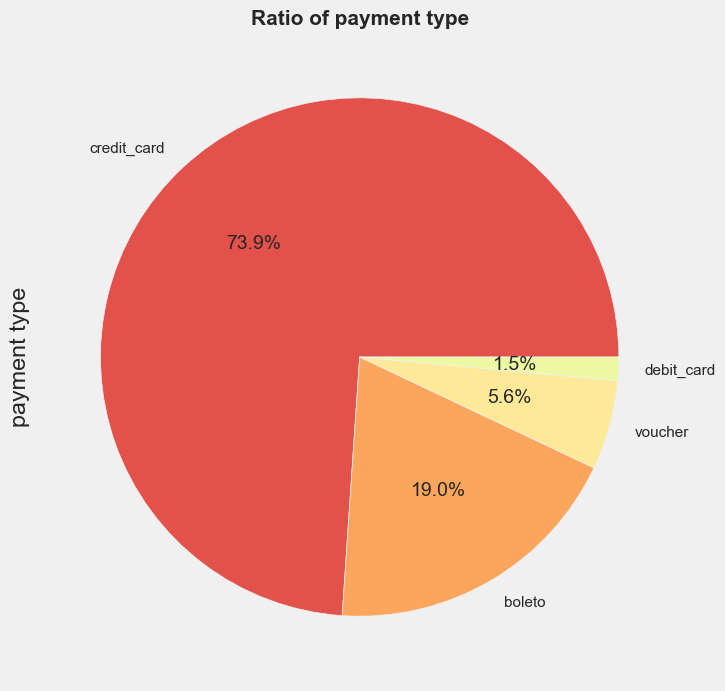

In [168]:
payment_type["payment_type"].value_counts().plot(kind= "pie",colors =sns.color_palette("Spectral") ,autopct='%1.1f%%')
plt.ylabel("payment type")
plt.title ( "Ratio of payment type", fontsize = 15, fontweight= "bold")

In [170]:
payment_type = pd.read_sql_query(""" select 
payment_type,
count (order_id) as payment_usage 
from payments
where payment_type != 'not_defined'
GROUP BY 1
order by 2 desc;""", connector)
payment_type 

,payment_type,payment_usage
0,credit_card,76795
1,boleto,19784
2,voucher,5775
3,debit_card,1529


In [293]:
payment_detail = pd.read_sql_query("""-- detail information payment type
with payment_use as (
select 
extract(year from order_purchase_timestamp) as year,
py.payment_type,
count(2) as payment_usage
from payments py
left JOIN orders o 
on py.order_id = o.order_id
where py.payment_type != 'not_defined'
GROUP BY 1,2
) --- karena tahun 2016 memiliki keterbatasan data maka hanya akan menghitung dari tahun 2017 dan 2018 saja.
select 
payment_type,
sum(case when year = '2017' then payment_usage else 0 end ) as year_2017,
sum(case when year = '2018' then payment_usage else 0 end ) as year_2018,
sum(payment_usage) as total_payment_usage
from payment_use 
GROUP BY 1
order by 4 desc;""", connector)
convert = ["year_2017","year_2018", "total_payment_usage"]
payment_detail[convert] = payment_detail[convert].astype("Int64")
payment_detail

,payment_type,year_2017,year_2018,total_payment_usage
0,credit_card,34568,41969,76795
1,boleto,9508,10213,19784
2,voucher,3027,2725,5775
3,debit_card,422,1105,1529


Text(0.801, 42000, '\ncredit card adalah metode pembayaran \nyang banyak digunakan untuk pembayaran\njika diakumulasikan dari tahun 2017 dan 2018 \nsekitar 73% lebih banyak penggunaanya dibandingkan\nmetode pembayaran lainya.\n\n')

<Figure size 1000x900 with 0 Axes>

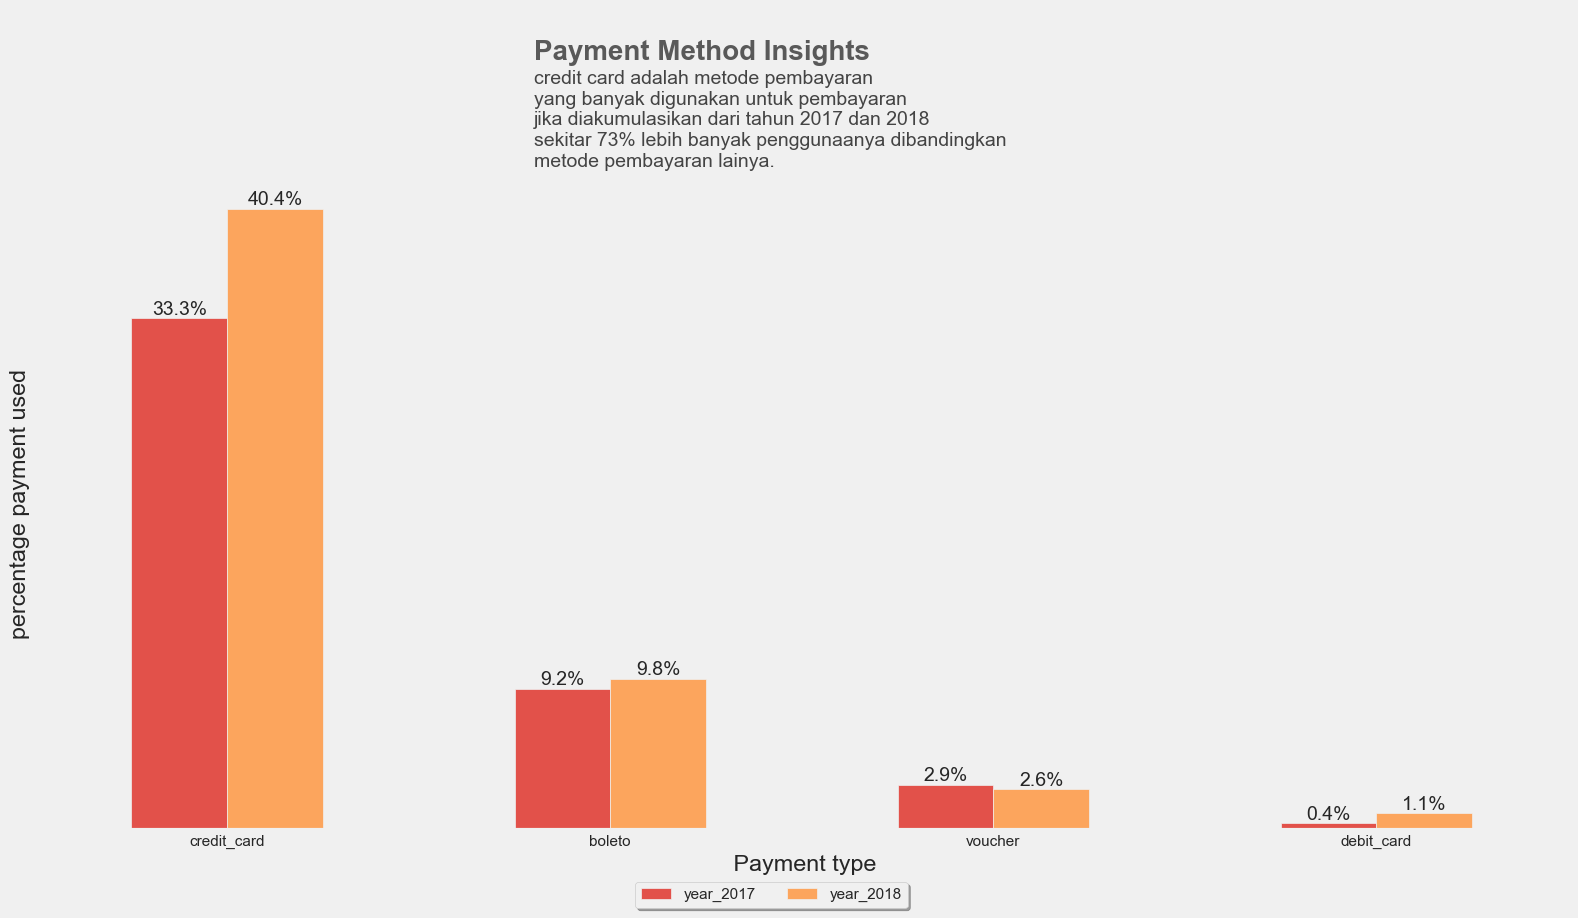

In [292]:
plt.figure(figsize= (10,9))
total_sum= sum(payment_detail.total_payment_usage)
payment = payment_detail.plot(x="payment_type", y = ["year_2017","year_2018" ] , kind= "bar", color=sns.color_palette("Spectral"))
plt.legend(loc='center', bbox_to_anchor=(0.48, -0.10),
          fancybox=True, shadow=True, ncol=5)
for value in payment.containers :
    plt.bar_label(value, fmt=lambda x: f'{(x/total_sum)*100:0.1f}%')

plt.ylabel("percentage payment used")
plt.grid("")
plt.tight_layout()
plt.yticks([])
plt.xlabel(" Payment type")
plt.tight_layout()
plt.xticks(rotation = 0)
title = """
Payment Method Insights
"""
# set text
text = """
credit card adalah metode pembayaran 
yang banyak digunakan untuk pembayaran
jika diakumulasikan dari tahun 2017 dan 2018 
sekitar 73% lebih banyak penggunaanya dibandingkan
metode pembayaran lainya.

"""

plt.text(x = 0.801, y = 50000, s=title,
        fontsize = 20, weight = 'bold', alpha = .75)
plt.text(x = 0.801, y = 42000, s=text,
        fontsize = 14, alpha = .85)

insight yang bisa didapat dari dua grafik diatas credit card mengalami  kenaikan yang lumayan sebesar 7% dari 2017 ke 2018 hal ini memungkinkan jika kedepanya credit card akan terus naik pengguna nya, karena menurut sumber https://www.cermati.com/artikel/8-alasan-mengapa-kamu-harus-memiliki-kartu-kredit, Kartu kredit merupakan alat transaksi pembayaran praktis nontunai, membeli barang jika uang tunai tidak cukup, aman dan sudah banyak digunakan oleh masyarakat. ini bisa terjadi mungkin karena promosi dari credit card tepat untuk masyarakat dan menyebabkan pengguna dari credit card terus meningkat.

In [195]:
payment_detail

,payment_type,year_2017,year_2018,total_payment_usage
0,credit_card,34568.0,41969.0,76795.0
1,boleto,9508.0,10213.0,19784.0
2,voucher,3027.0,2725.0,5775.0
3,debit_card,422.0,1105.0,1529.0


In [204]:
total_pemakaian_cash = 5000000
total_pemakaian_credit_card = 3000
total_pemakaian_debit_card = 2000

# Menghitung total pemakaian dari semua tipe pembayaran
total_pemakaian_total = total_pemakaian_cash + total_pemakaian_credit_card + total_pemakaian_debit_card

# Menghitung persentase pemakaian untuk setiap tipe pembayaran
persentase_cash = (total_pemakaian_cash / total_pemakaian_total) * 100
persentase_credit_card = (total_pemakaian_credit_card / total_pemakaian_total) * 100
persentase_debit_card = (total_pemakaian_debit_card / total_pemakaian_total) * 100

# Menampilkan hasil
print("Persentase Pemakaian Cash: {:.2f}%".format(persentase_cash))
print("Persentase Pemakaian Credit Card: {:.2f}%".format(persentase_credit_card))
print("Persentase Pemakaian Debit Card: {:.2f}%".format(persentase_debit_card))

Persentase Pemakaian Cash: 99.90%
Persentase Pemakaian Credit Card: 0.06%
Persentase Pemakaian Debit Card: 0.04%


In [207]:
total_credit = (payment_detail["year_2017"] / payment_detail["total_payment_usage"]) 

In [236]:
total_sum= sum(payment_detail.total_payment_usage)

In [237]:
total_sum

103883